In [175]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [176]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).median(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).median(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir, skip=None):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
#     throughput_csv['rxpck/s'] *= 1e-6
#     throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir, skip=None):
    cpu_csv = pd.read_csv(f"{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    if skip is not None:
        cpu = cpu[cpu['client'] != skip]
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_decrypt(res_dir, skip=None):
    df = pd.read_csv(f"{res_dir}/summary/decrypt_time.csv")
    
    df = average_data(df, keep=['clients'])
    df = df.reset_index(drop=True)
    
    if skip is not None:
        df = df[df['clients'] != skip]

    cpu, pcpu = import_cpu(res_dir, skip=skip)
    cpu = cpu.reset_index(drop=True)

    df_2 = pd.concat([cpu, df], axis=1)
    df_2.decrypt_packet = df_2.decrypt_packet * df_2.used / 100
    df_2.spin_lock = df_2.spin_lock * df_2.used / 100
    df_2.decrypt_worker = df_2.decrypt_worker * df_2.used / 100

    keep = ['clients', 'decrypt_worker', 'decrypt_packet', 'spin_lock']
    
    return df[keep], df_2[keep]
    
    
def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).median().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir, skip=None):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).median().reset_index()
    
    if skip is not None:
        if not isinstance(skip, list):
            skip = [skip]
        latency_df = latency_df[~latency_df.client.isin(skip)]
    
    return latency_df

In [177]:
def infos_resdir(resdir):
    t = f"{maindir}/{resdir}"
    curr_dir_f = f"{t}/EXPERIMENT_DATA/CURRENT_EXP"
    
    with open(curr_dir_f) as f:
        curr_dir = f.readlines()[0].strip()
        name = curr_dir.split("-")[2]
    return {
        'test': curr_dir,
        'path': t,
        'name': name
    }
def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res['name'] == val:
            return k

In [178]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

In [193]:
skip = 1
names = ['VANILLA', 'CRYPTONCE']
naming = {
    'yes': 'VANILLA',
    'partial': "CRYPTONCE"
}
naming_2 = {
    'yes': 'VANILLA-v2',
    'partial': "CRYPTONCE-v2"
}
names_2 = ["VANILLA-v2", "CRYPTONCE-v2"]
ms = ['x', 'o', 's']
colors = ['black', 'red']

In [297]:
def compute_improvement(res_dirs, importer, metric, index='client', naming=naming):
    base = res_dirs[0]
    other = res_dirs[1]
    
    df_base = importer(base['path']).reset_index(drop=True)
    df_base = df_base[df_base[index] != skip]
    df_base = df_base.set_index(index)

    df_other = importer(other['path']).reset_index(drop=True)
    df_other = df_other[df_other[index] != skip]
    df_other = df_other.set_index(index)
    impr = (- df_other + df_base) * 100 / df_base
    diff = (- df_other + df_base)
    

    clients = list(diff.index)
    data_impr = list(impr[metric])
    data_diff = list(diff[metric])
    data = {
        'client': clients,
        'improvement': data_impr,
        'difference': data_diff,
    }

    out = pd.DataFrame(data).set_index('client')

    for res_dir in res_dirs:
        df = importer(res_dir['path'])
        df = df[df[index] != skip].set_index(index)
        out[naming[res_dir['name']]] = df[metric]
    
    return out

def import_decrypt_absolute(res_dir, skip=None):
    return import_decrypt(res_dir, skip=skip)[1]

def plot_improvement(out, savefig=None, ylabel='CPU Usage (in \%)', ylim=[0, 1], figsize=(8, 5),
                     space=1, names=names, annotate="improvement", colors=colors, n_cols=1,
                     legend_size=11, columnspacing=1.5, width=.8):
    with plt.style.context(['science', 'ieee']):
        ax = out[names].plot.bar(
            ylim=ylim, figsize=figsize,
            xlabel='Clients', ylabel=ylabel,
            grid=True, color=colors, width=width,
        )

        if annotate is not None:
            for k, i in enumerate(out.index):
                max_height = out.loc[i, names[0]]  # Position at the higher bar
                ax.text(k, max_height + space, f'{out.loc[i, annotate]:.2f}\%', 
                        ha='center', fontsize=12)

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":legend_size}, ncol=n_cols, columnspacing=1.5)
        if savefig is not None:
            plt.savefig(savefig, dpi=300)

In [298]:
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

,improvement,difference,VANILLA,CRYPTONCE
client,,,,
20,66.870136,2.332758,3.488490,1.155732
50,65.197406,6.893072,10.572617,3.679545
80,65.623030,13.469800,20.526025,7.056225
100,67.812922,19.392102,28.596470,9.204368


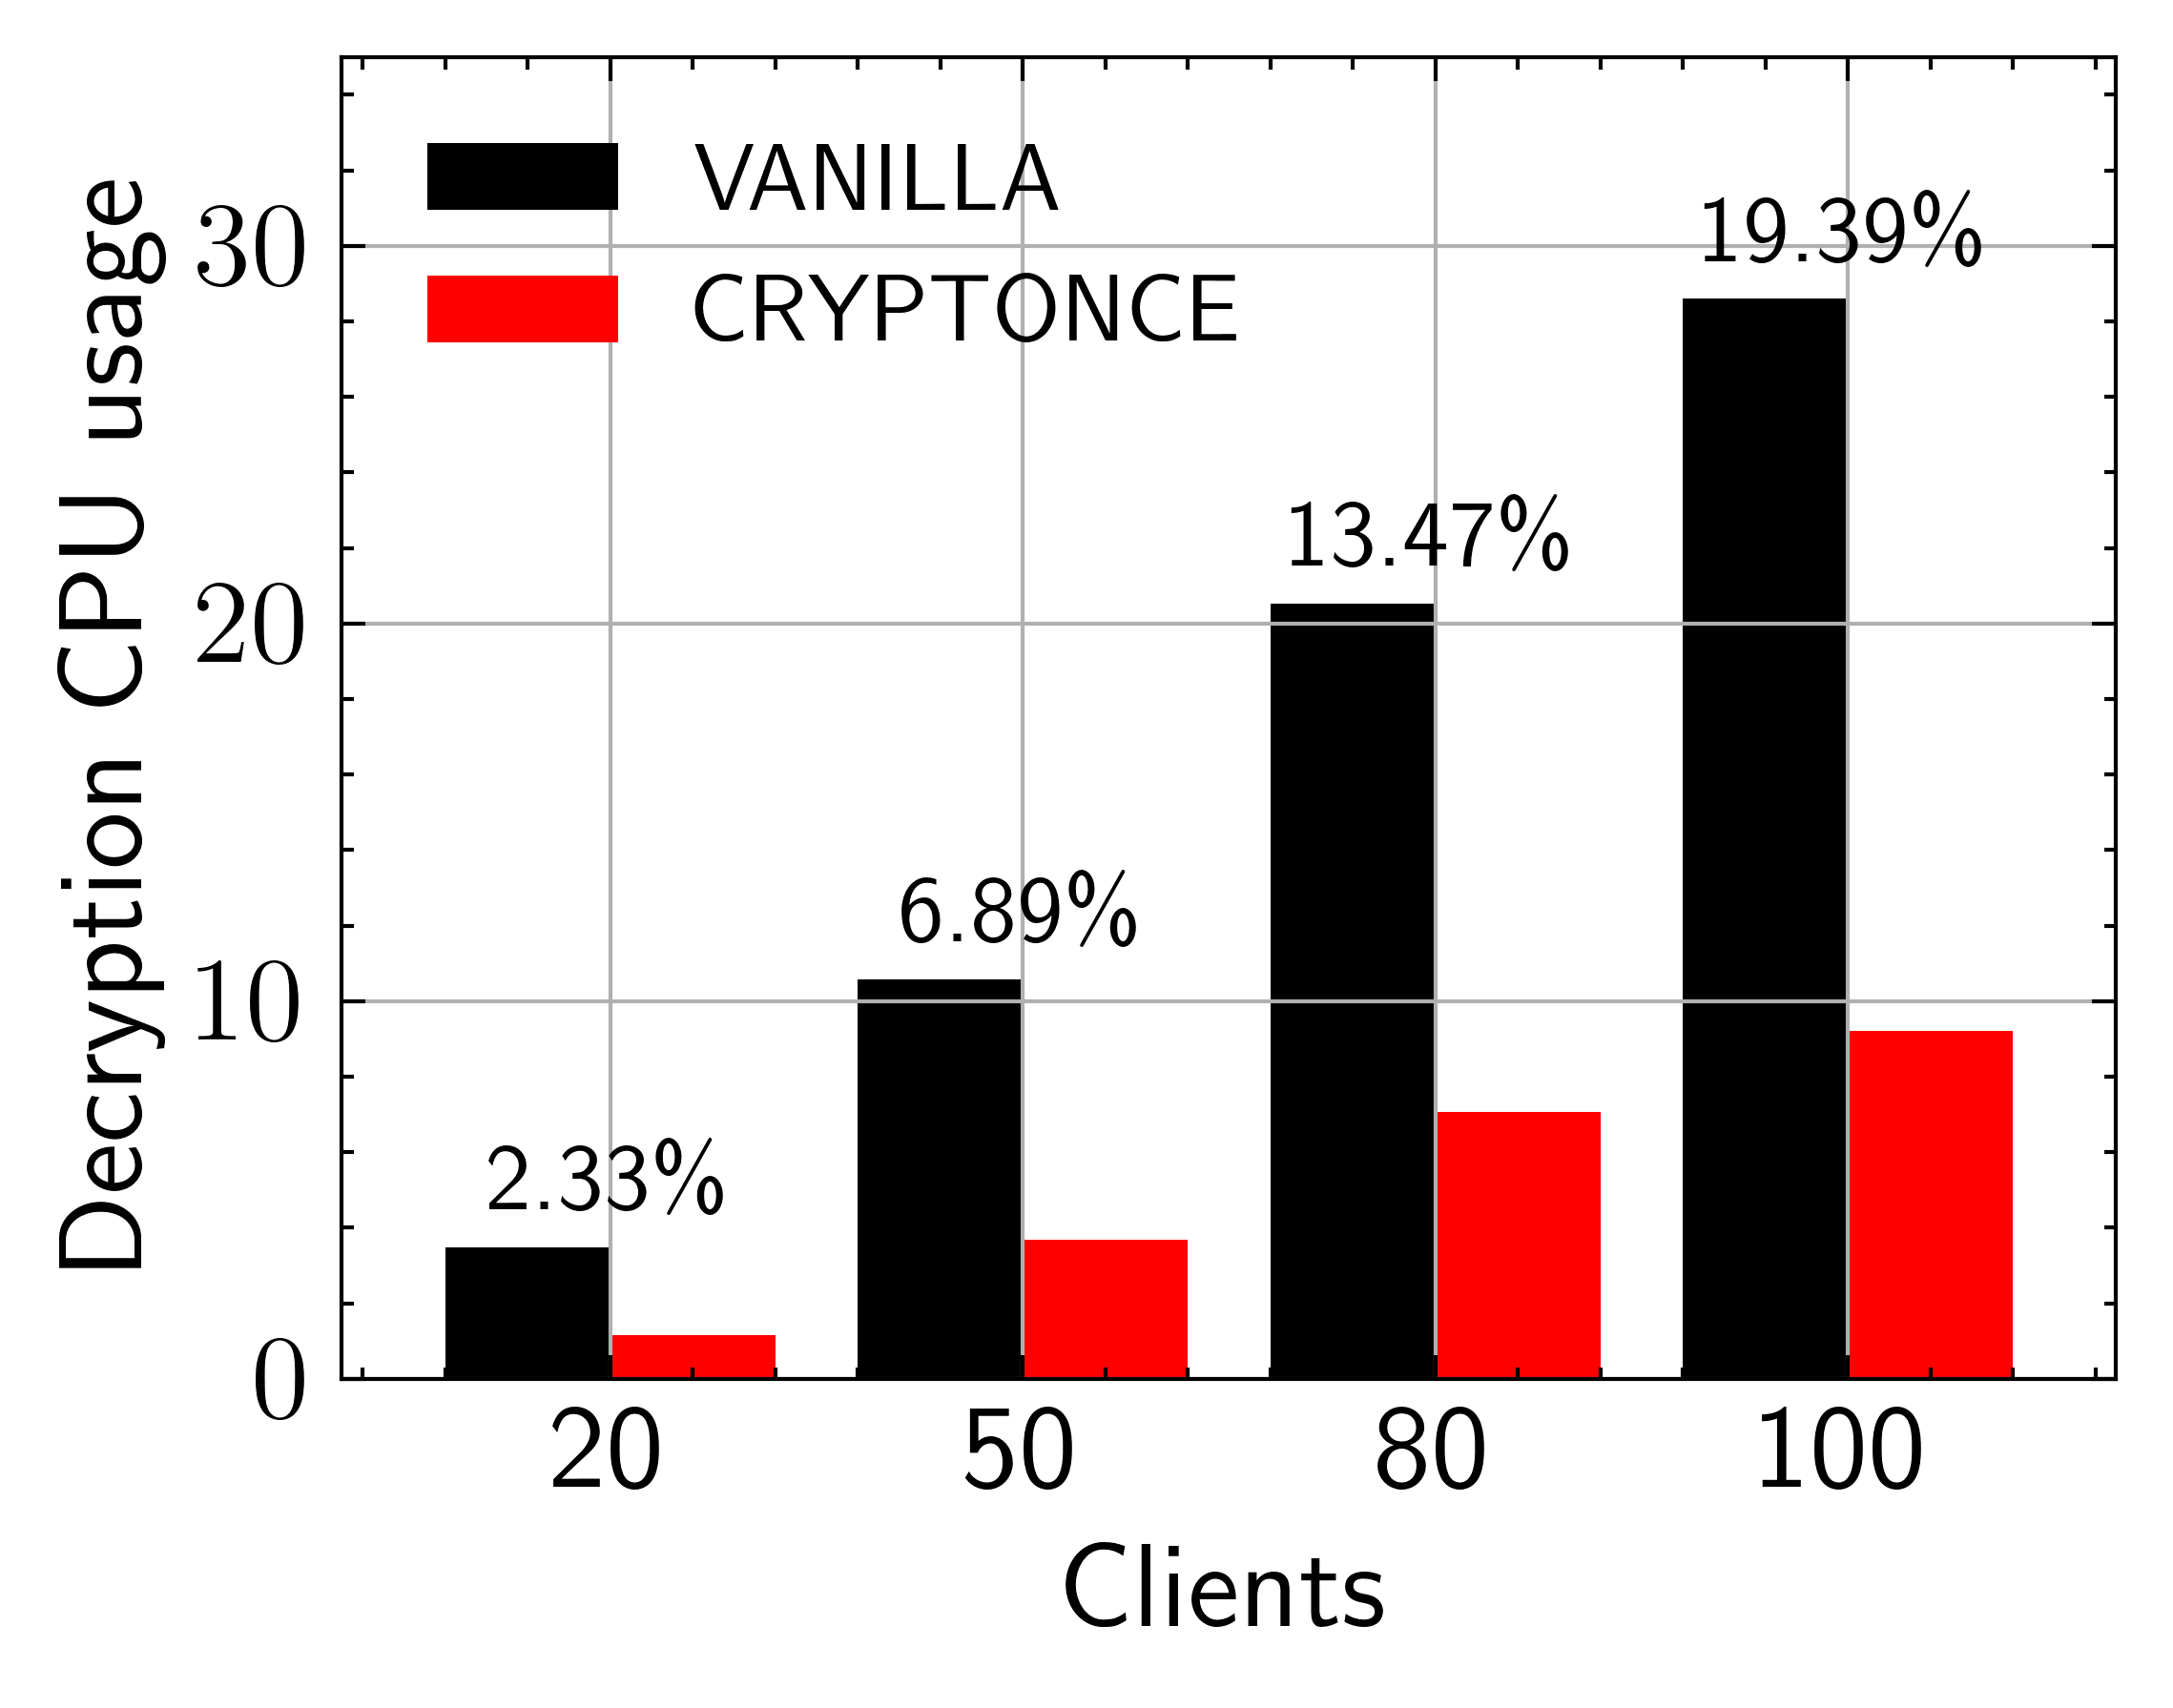

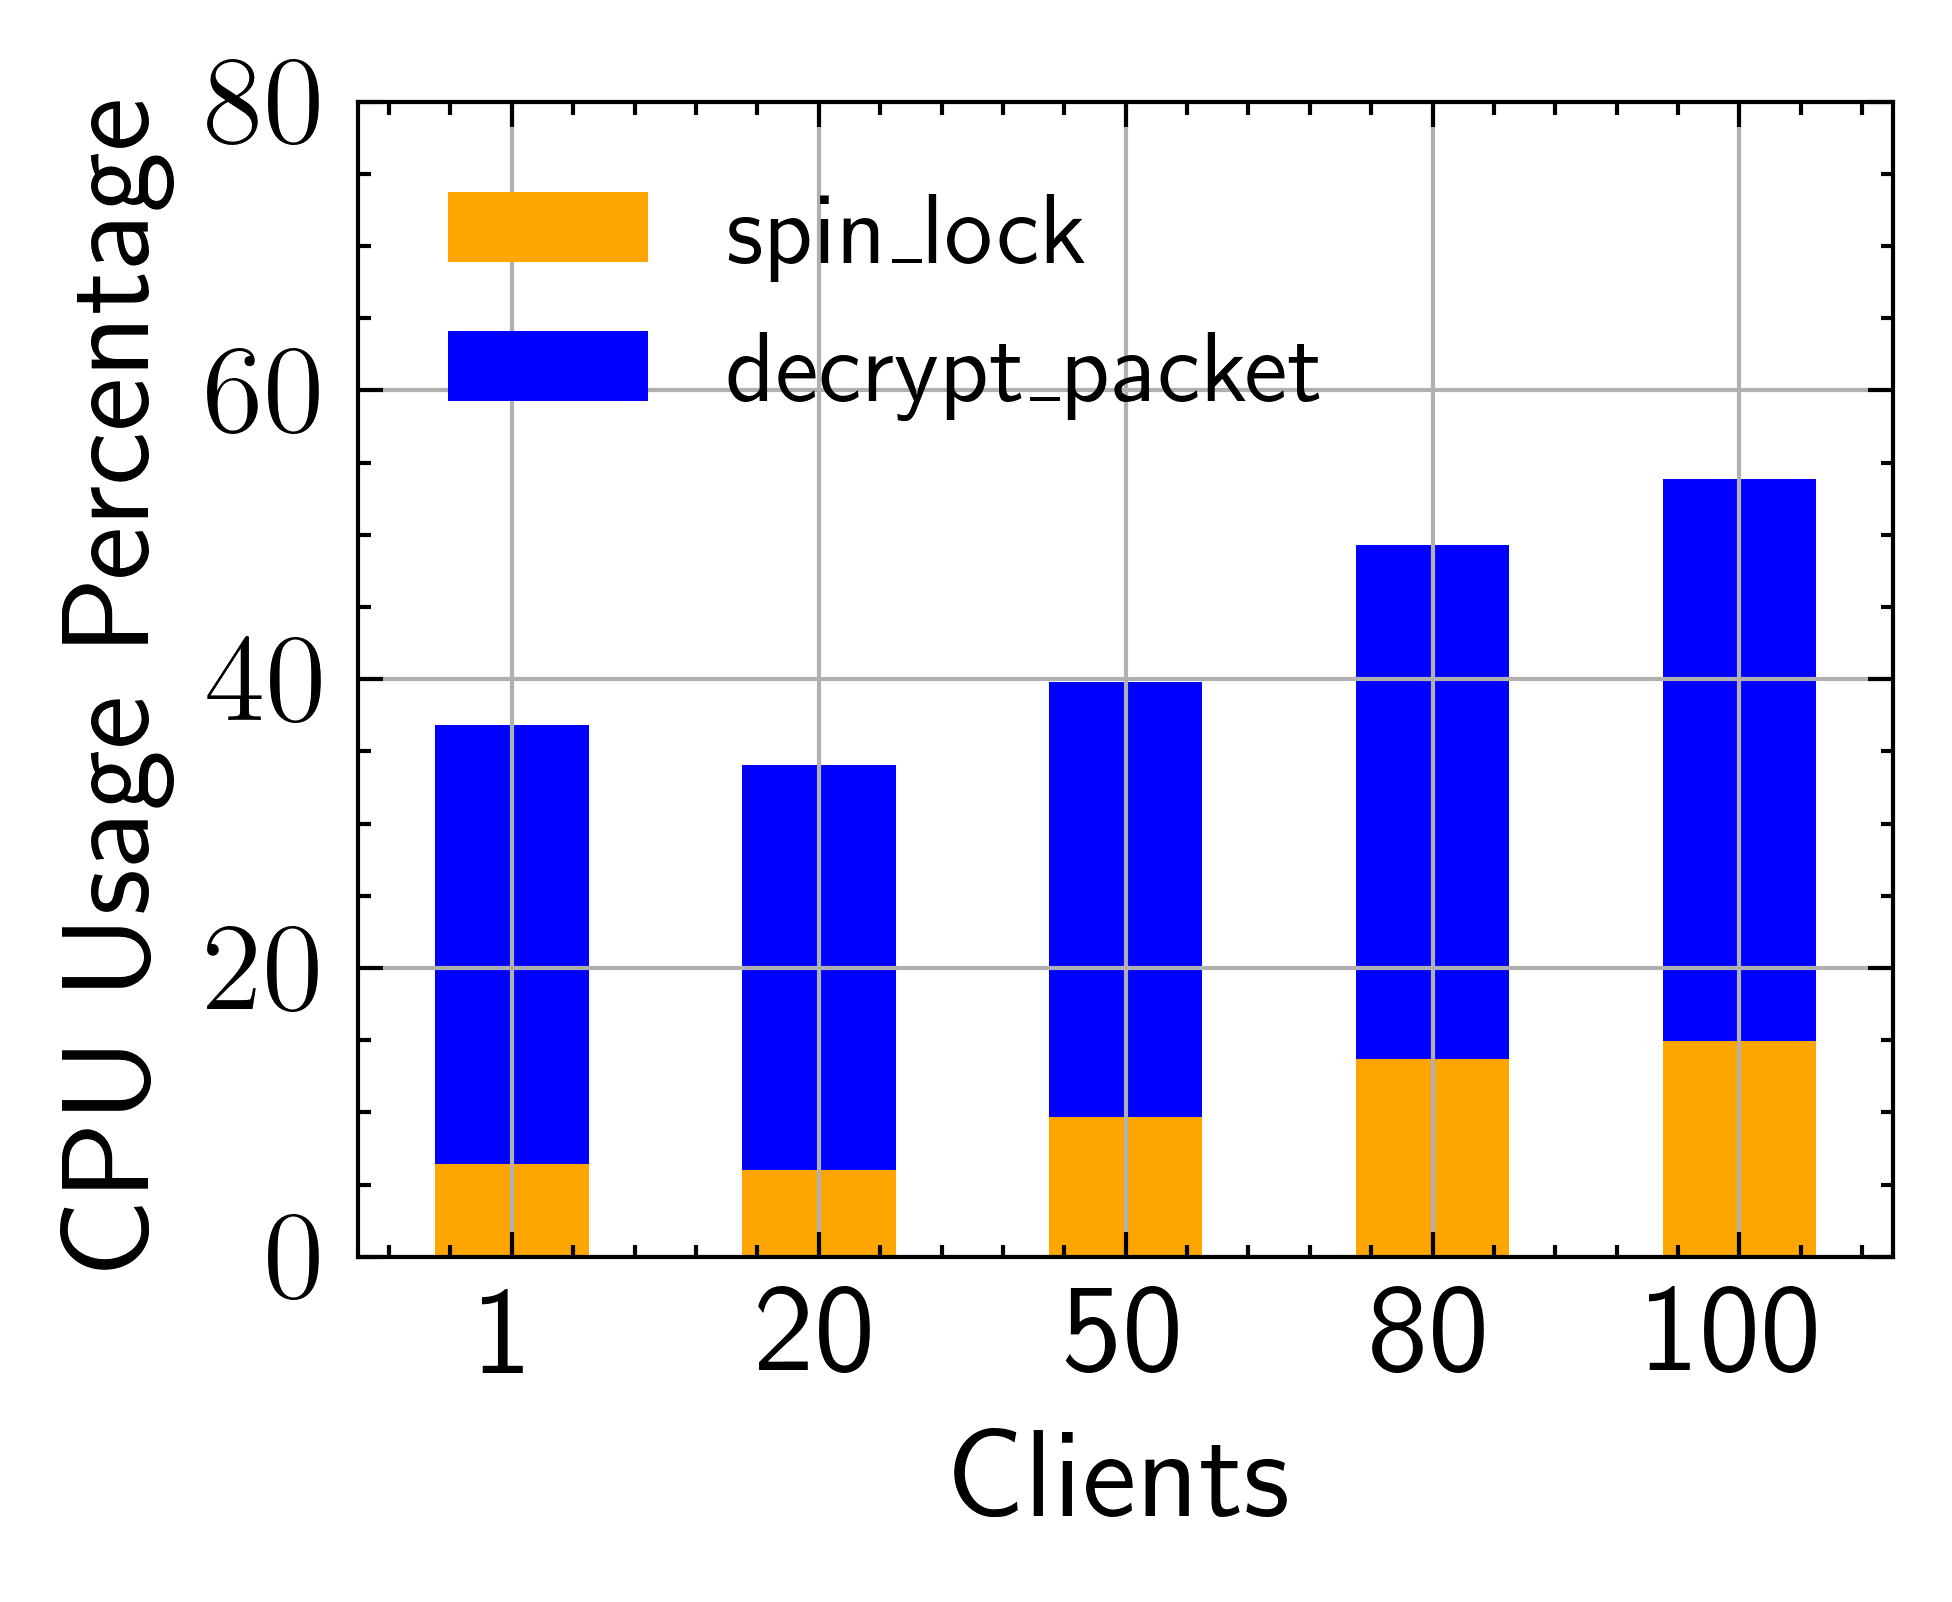

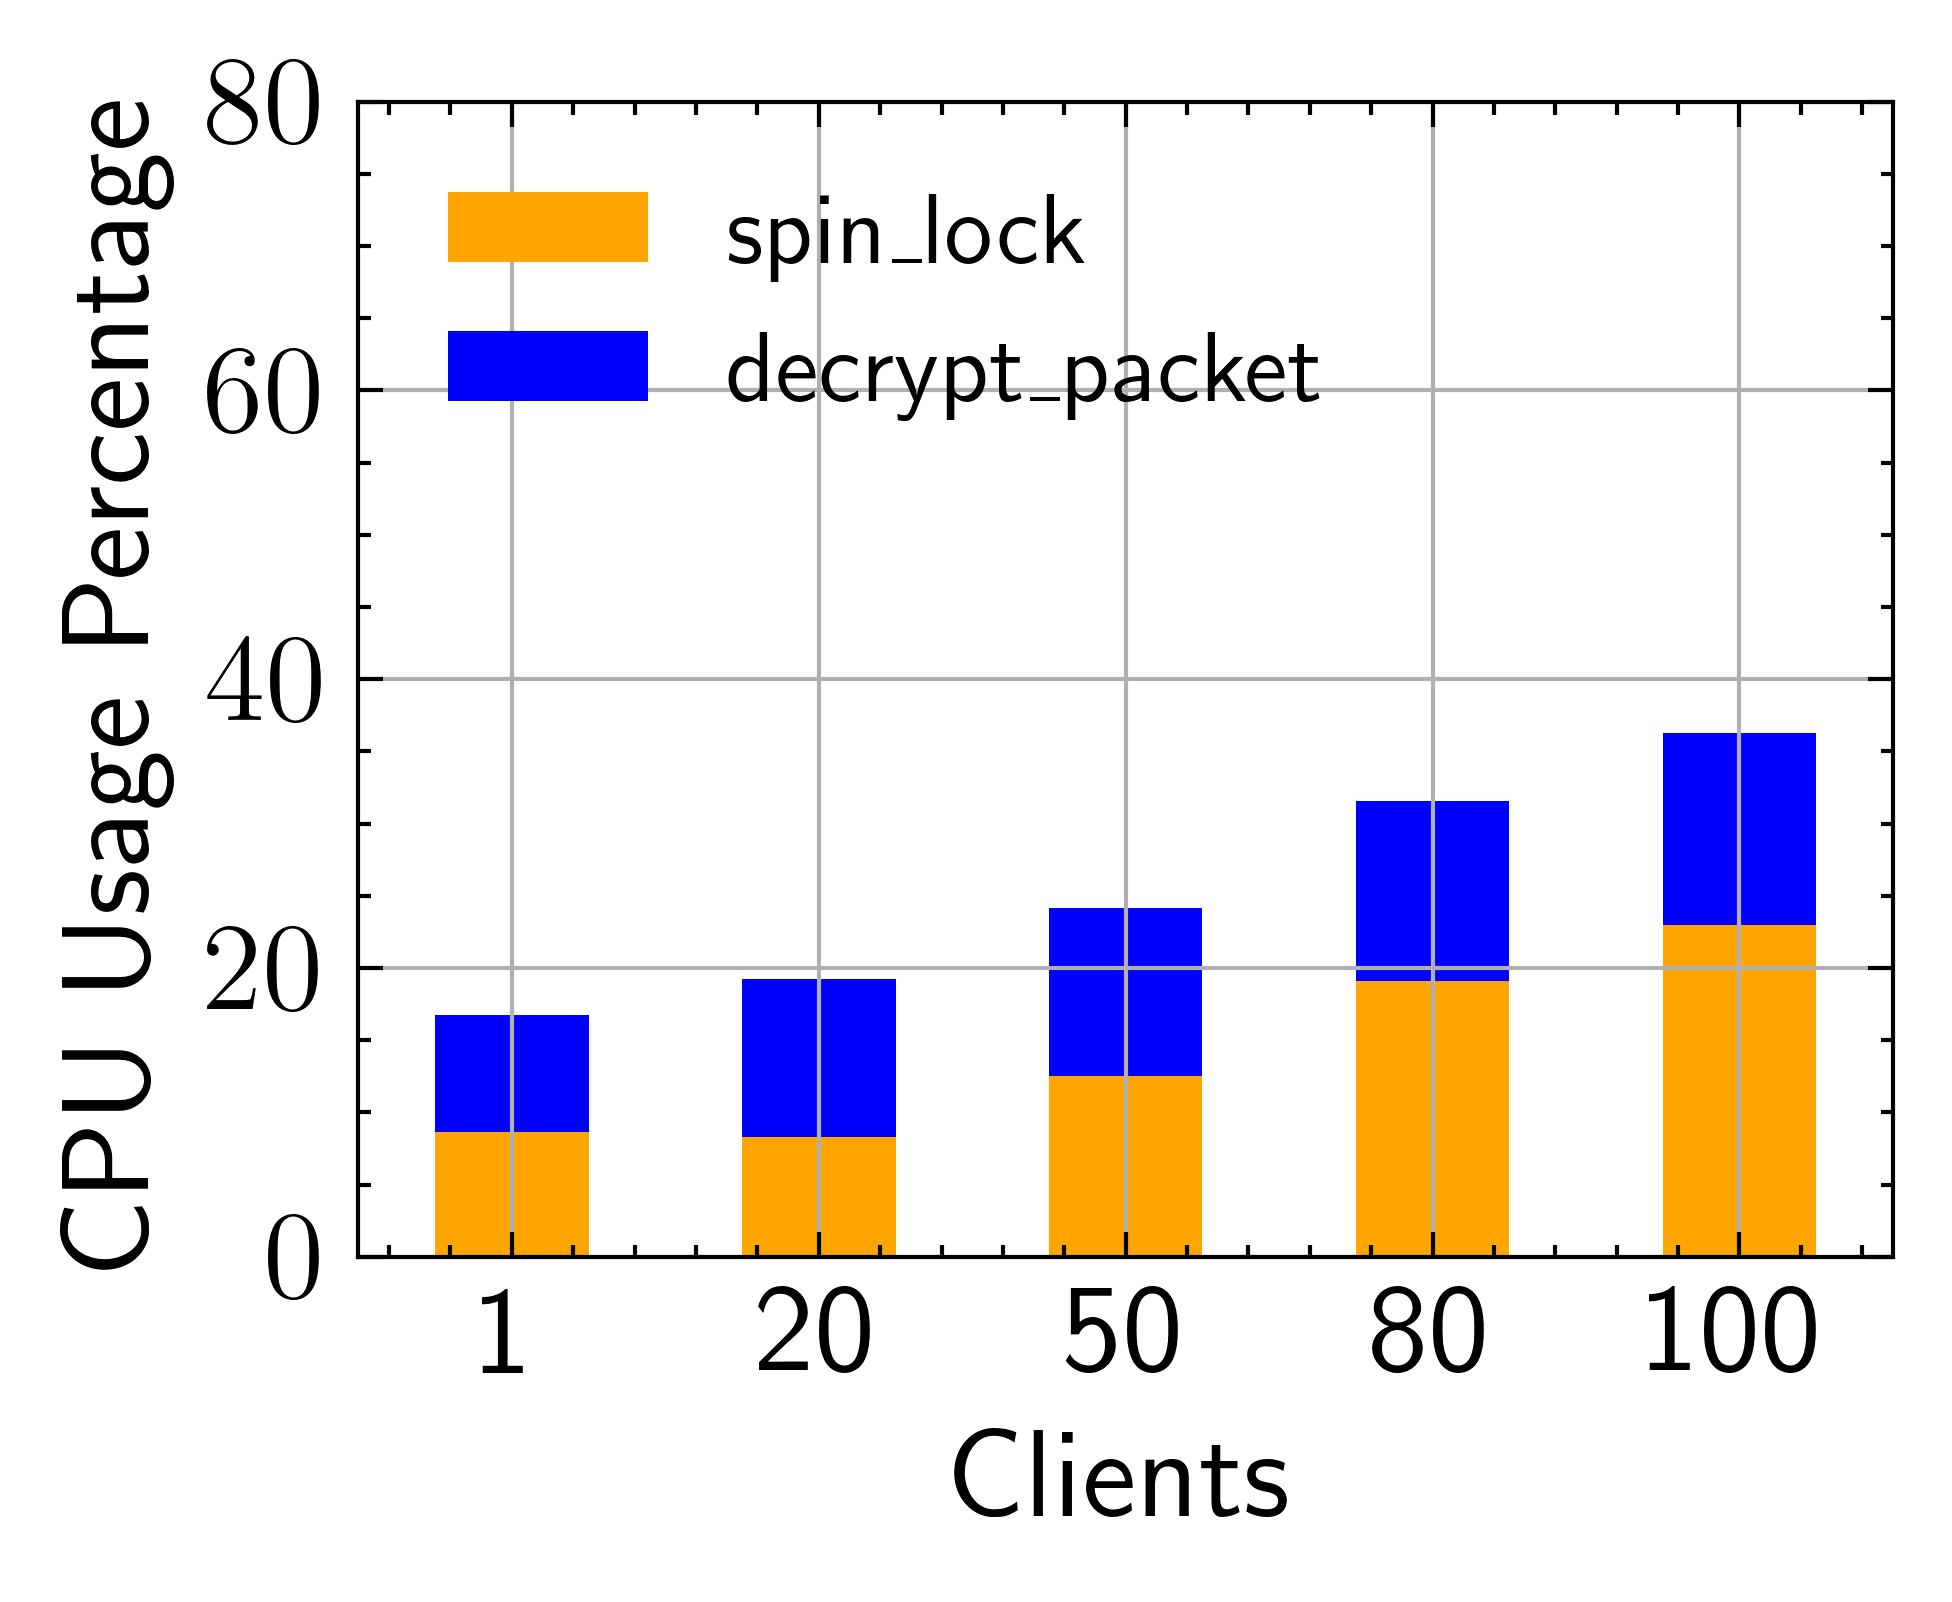

In [300]:
dir_ = "cryptonce-v1-1"
skip = 1
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
index = find_index(res_dirs, 'no')
res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass

colors = ['black', 'red']
out = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_packet', index='clients')
plot_improvement(out, ylabel="Decryption CPU usage", annotate='difference',
                 ylim=[0, 35], space=1, colors=colors, n_cols=1, legend_size=12, 
                 savefig=f"../graphs/{dir_}/decryption_cpu.pdf",
                 figsize=(4, 3),
)

cols = ['spin_lock', 'decrypt_packet']
colors = ['orange', 'blue']

for res in res_dirs:
    df = import_decrypt(res['path'])[0].set_index('clients')
    with plt.style.context(['science', 'ieee']):
        df[cols].plot.bar(
            xlabel="Clients", ylabel="CPU Usage Percentage",
            stacked=True, ylim=[0, 80], color=colors, grid=True,
        )

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":12})
        plt.savefig(f"../graphs/{dir_}/spinratios_{res['name']}.pdf", dpi=300)
out

,improvement,difference,VANILLA-v2,CRYPTONCE-v2
client,,,,
20,53.506184,1.246006,2.328714,1.082708
50,66.278592,6.929823,10.455597,3.525774
80,62.983447,10.211968,16.213733,6.001765
100,62.312834,12.291062,19.724768,7.433706


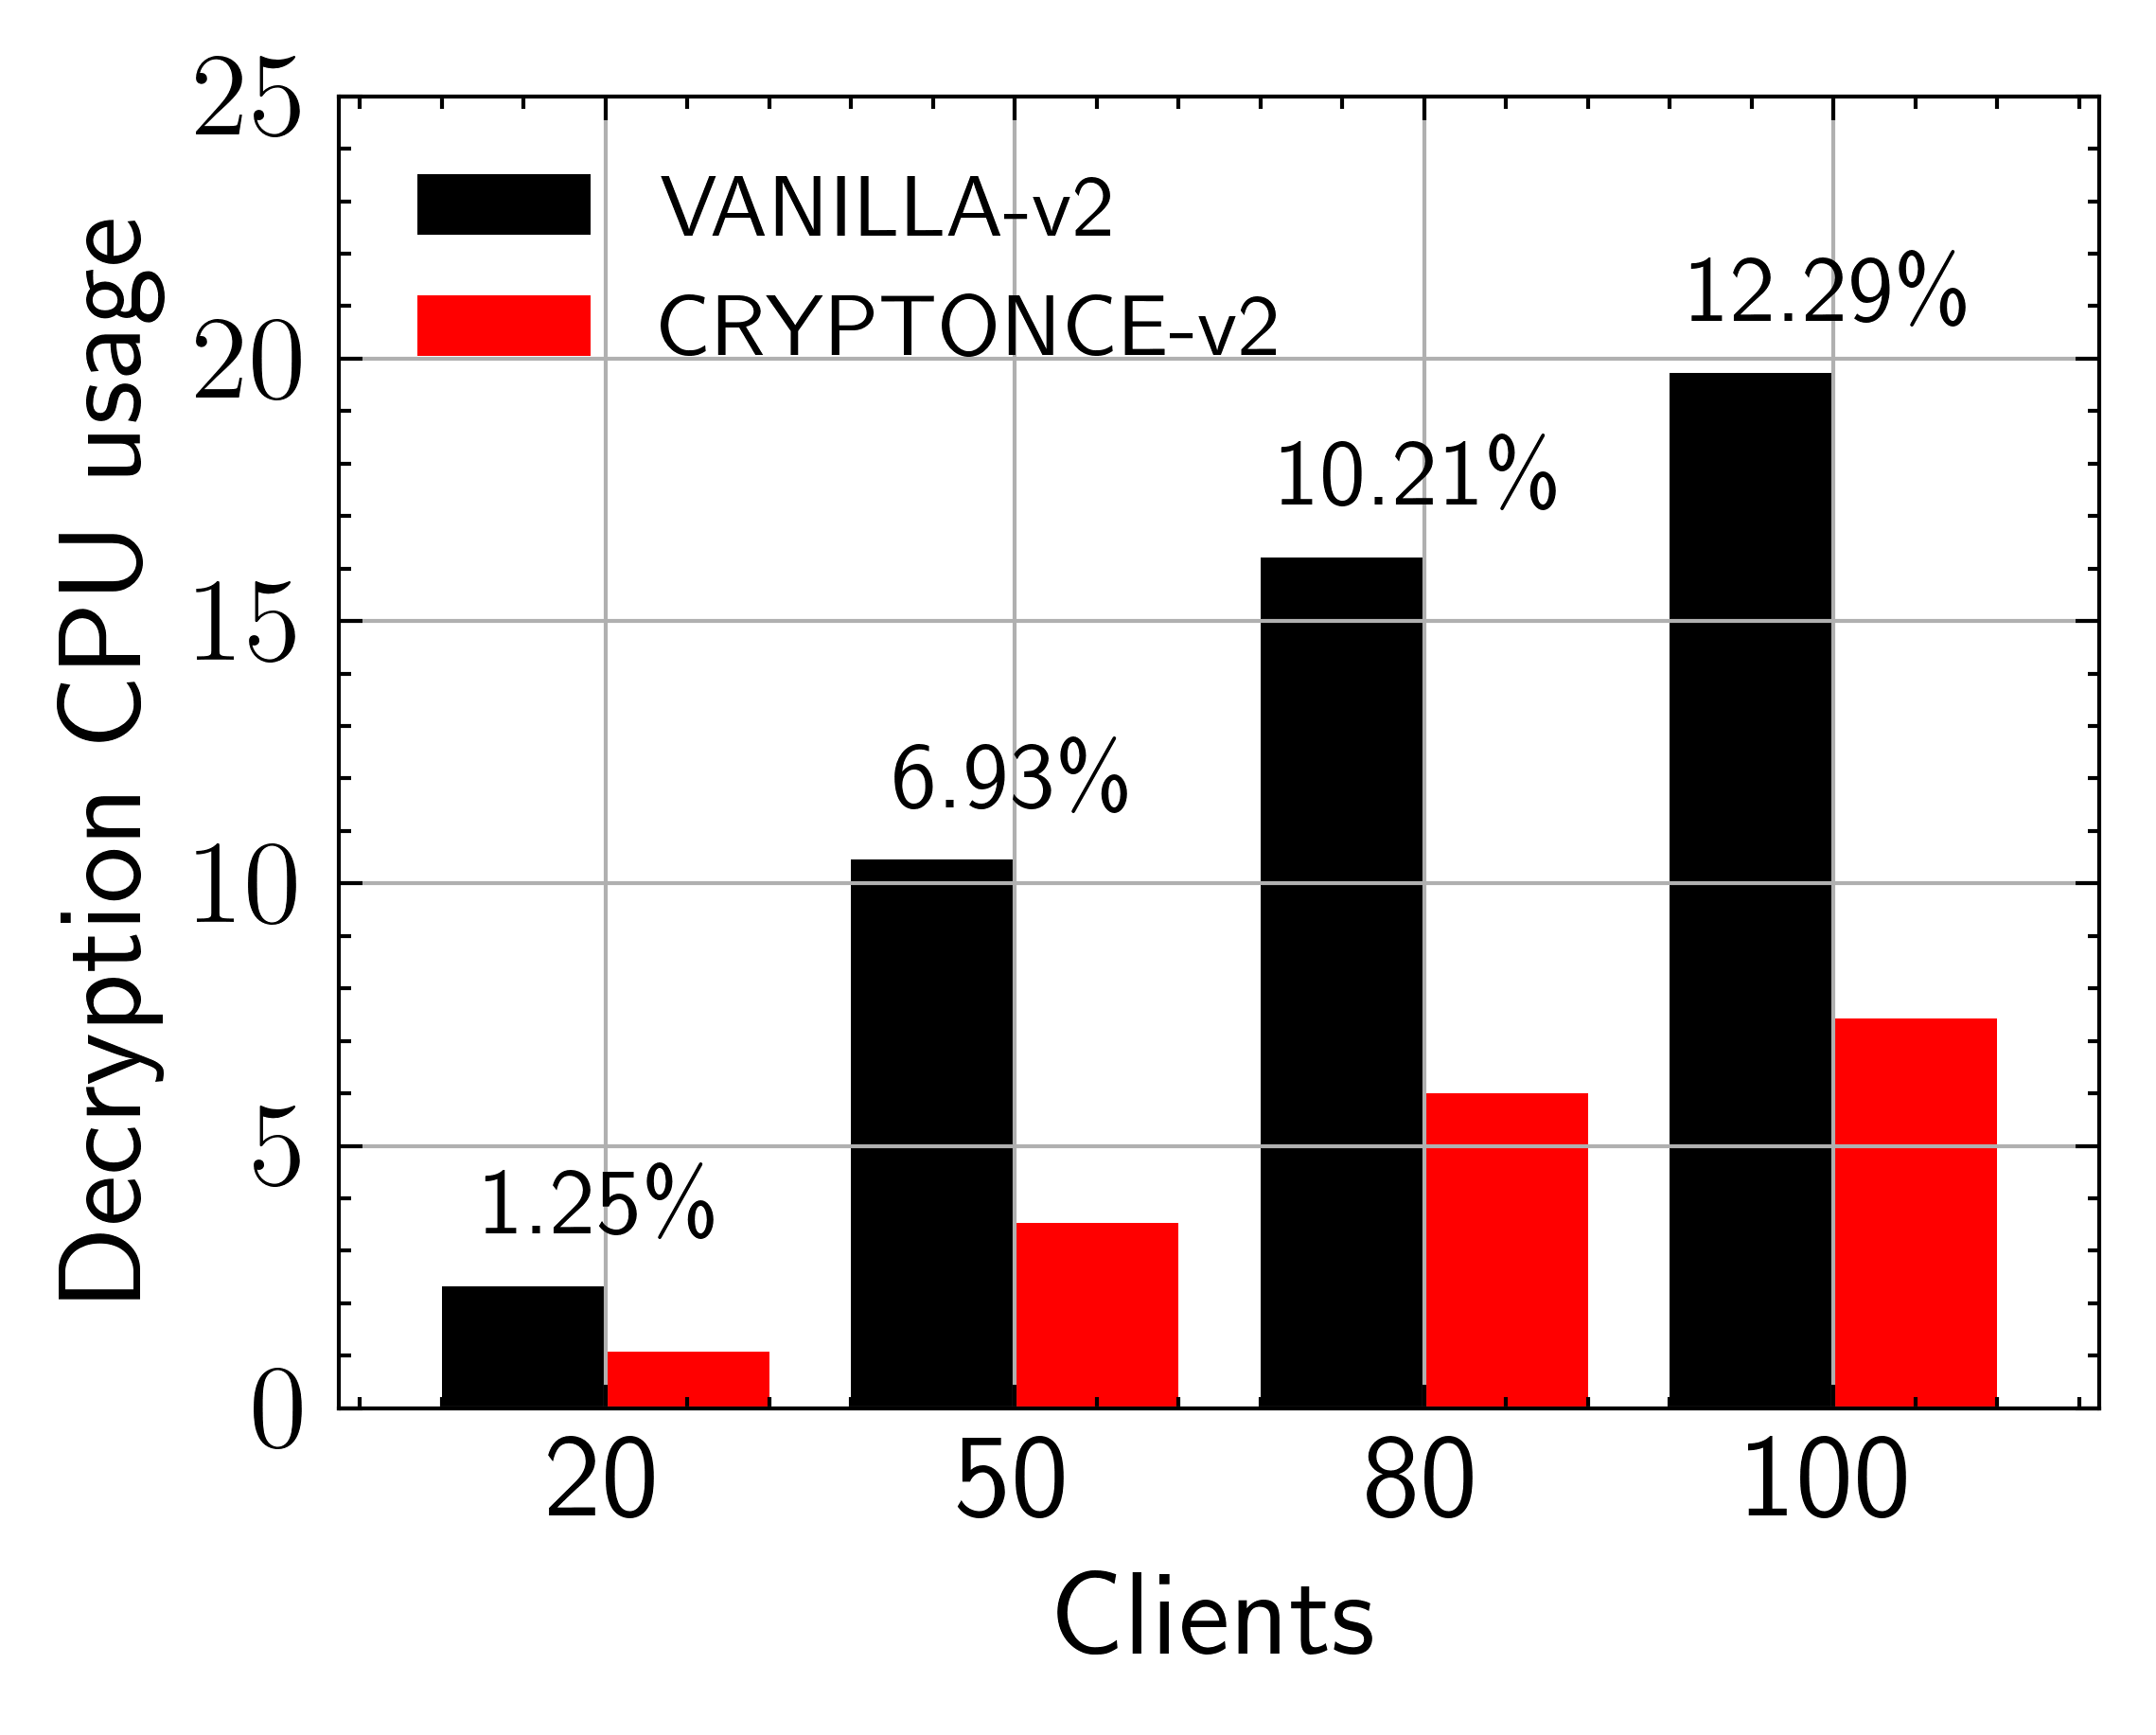

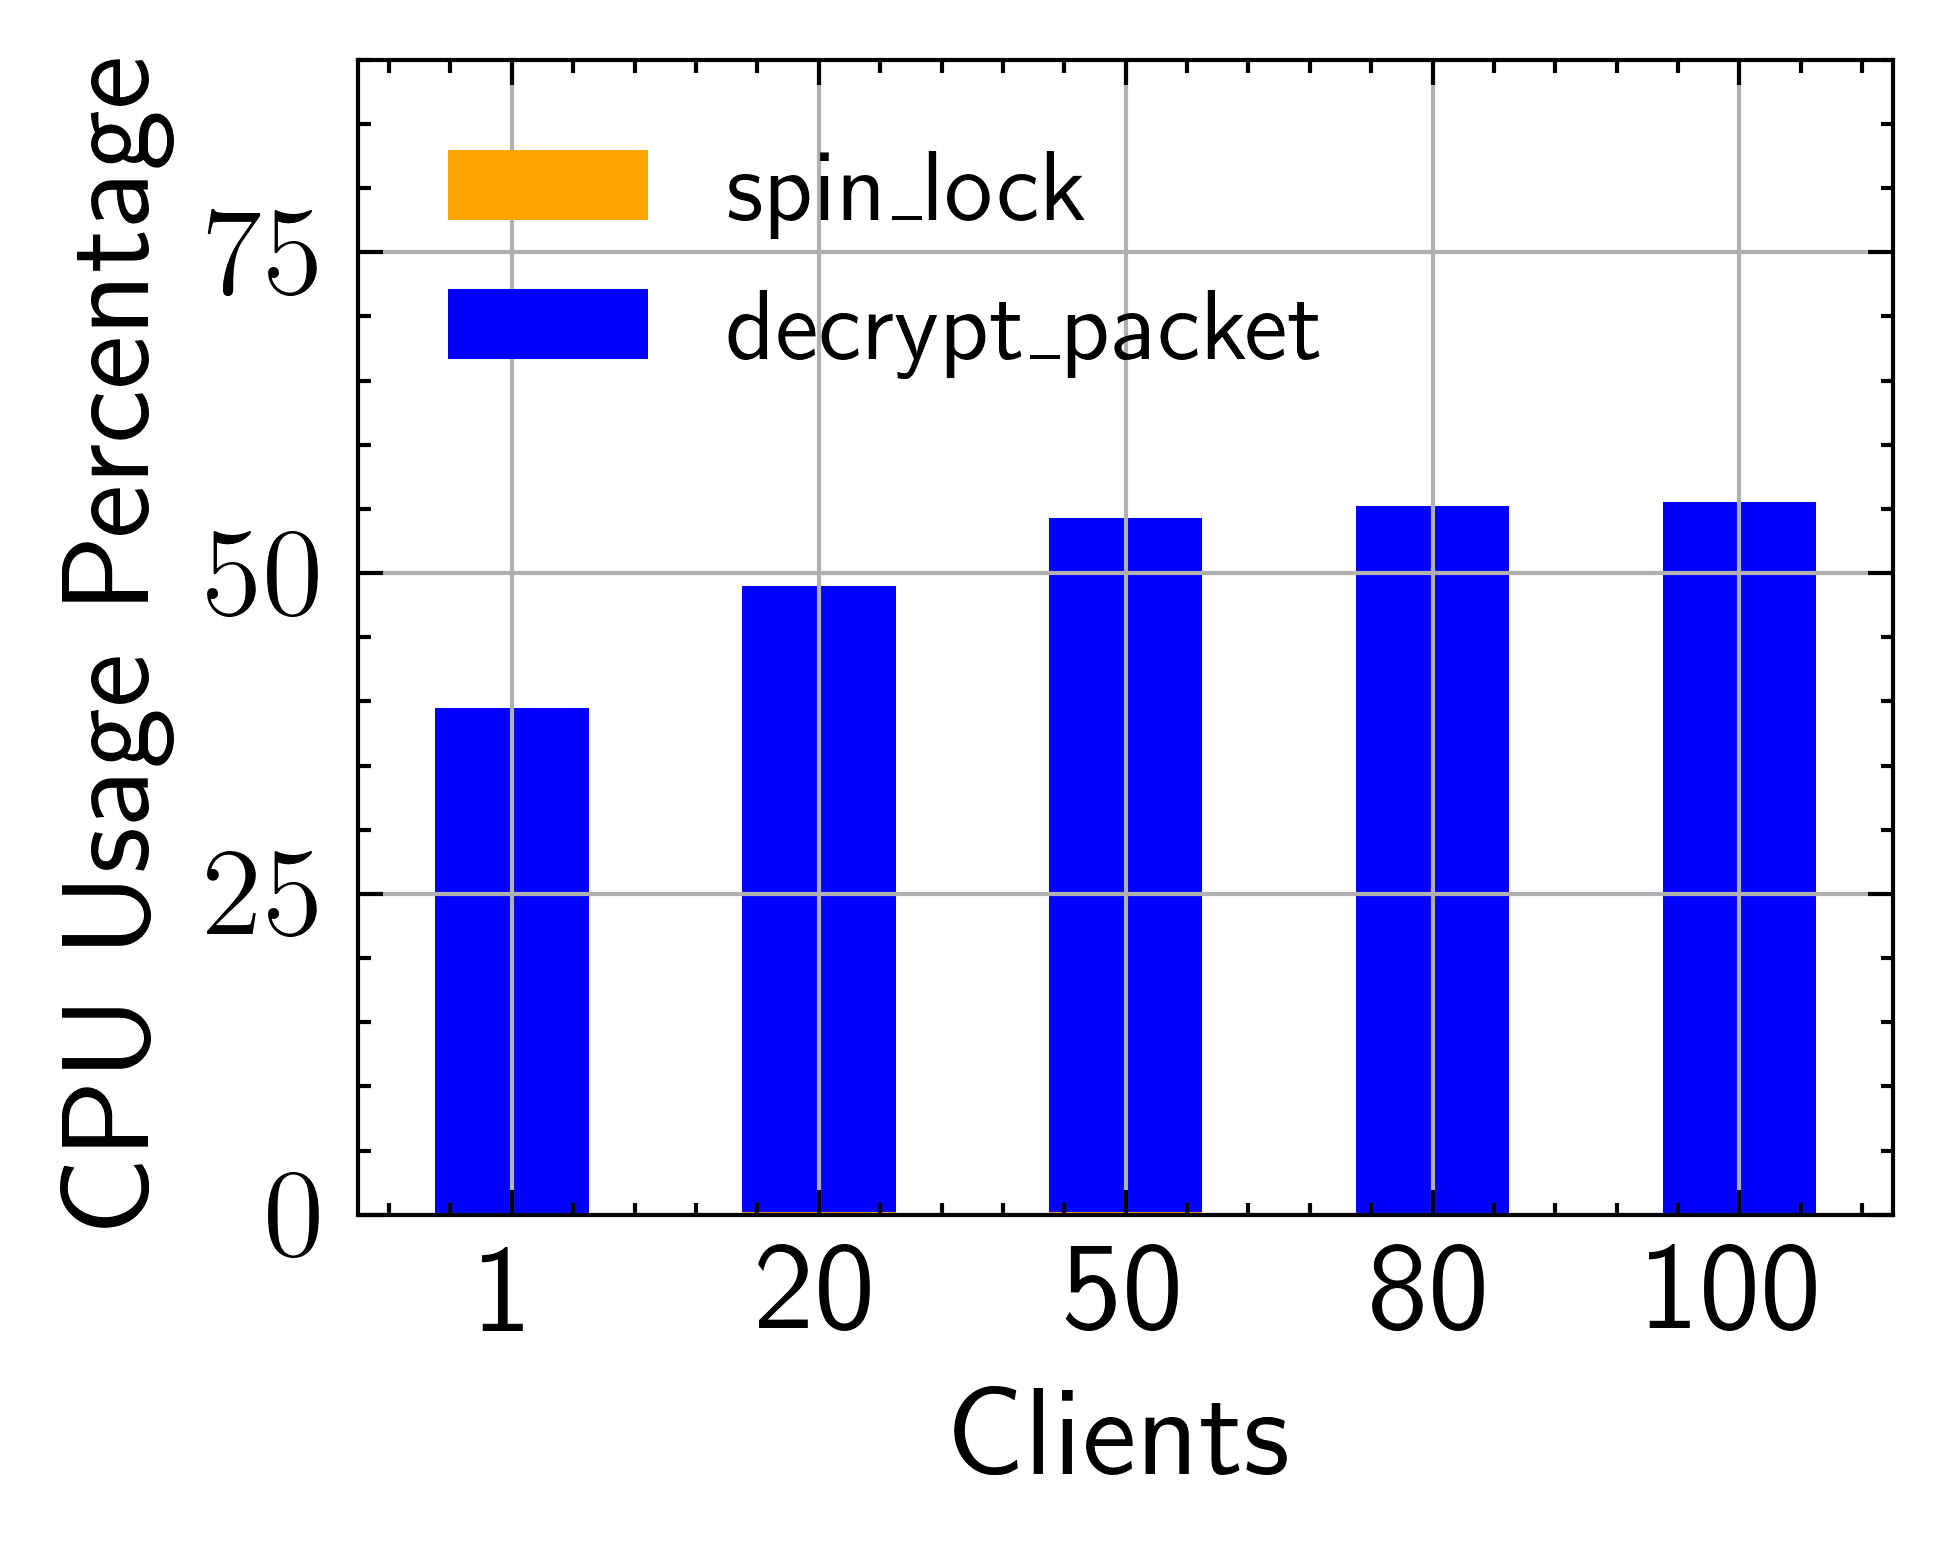

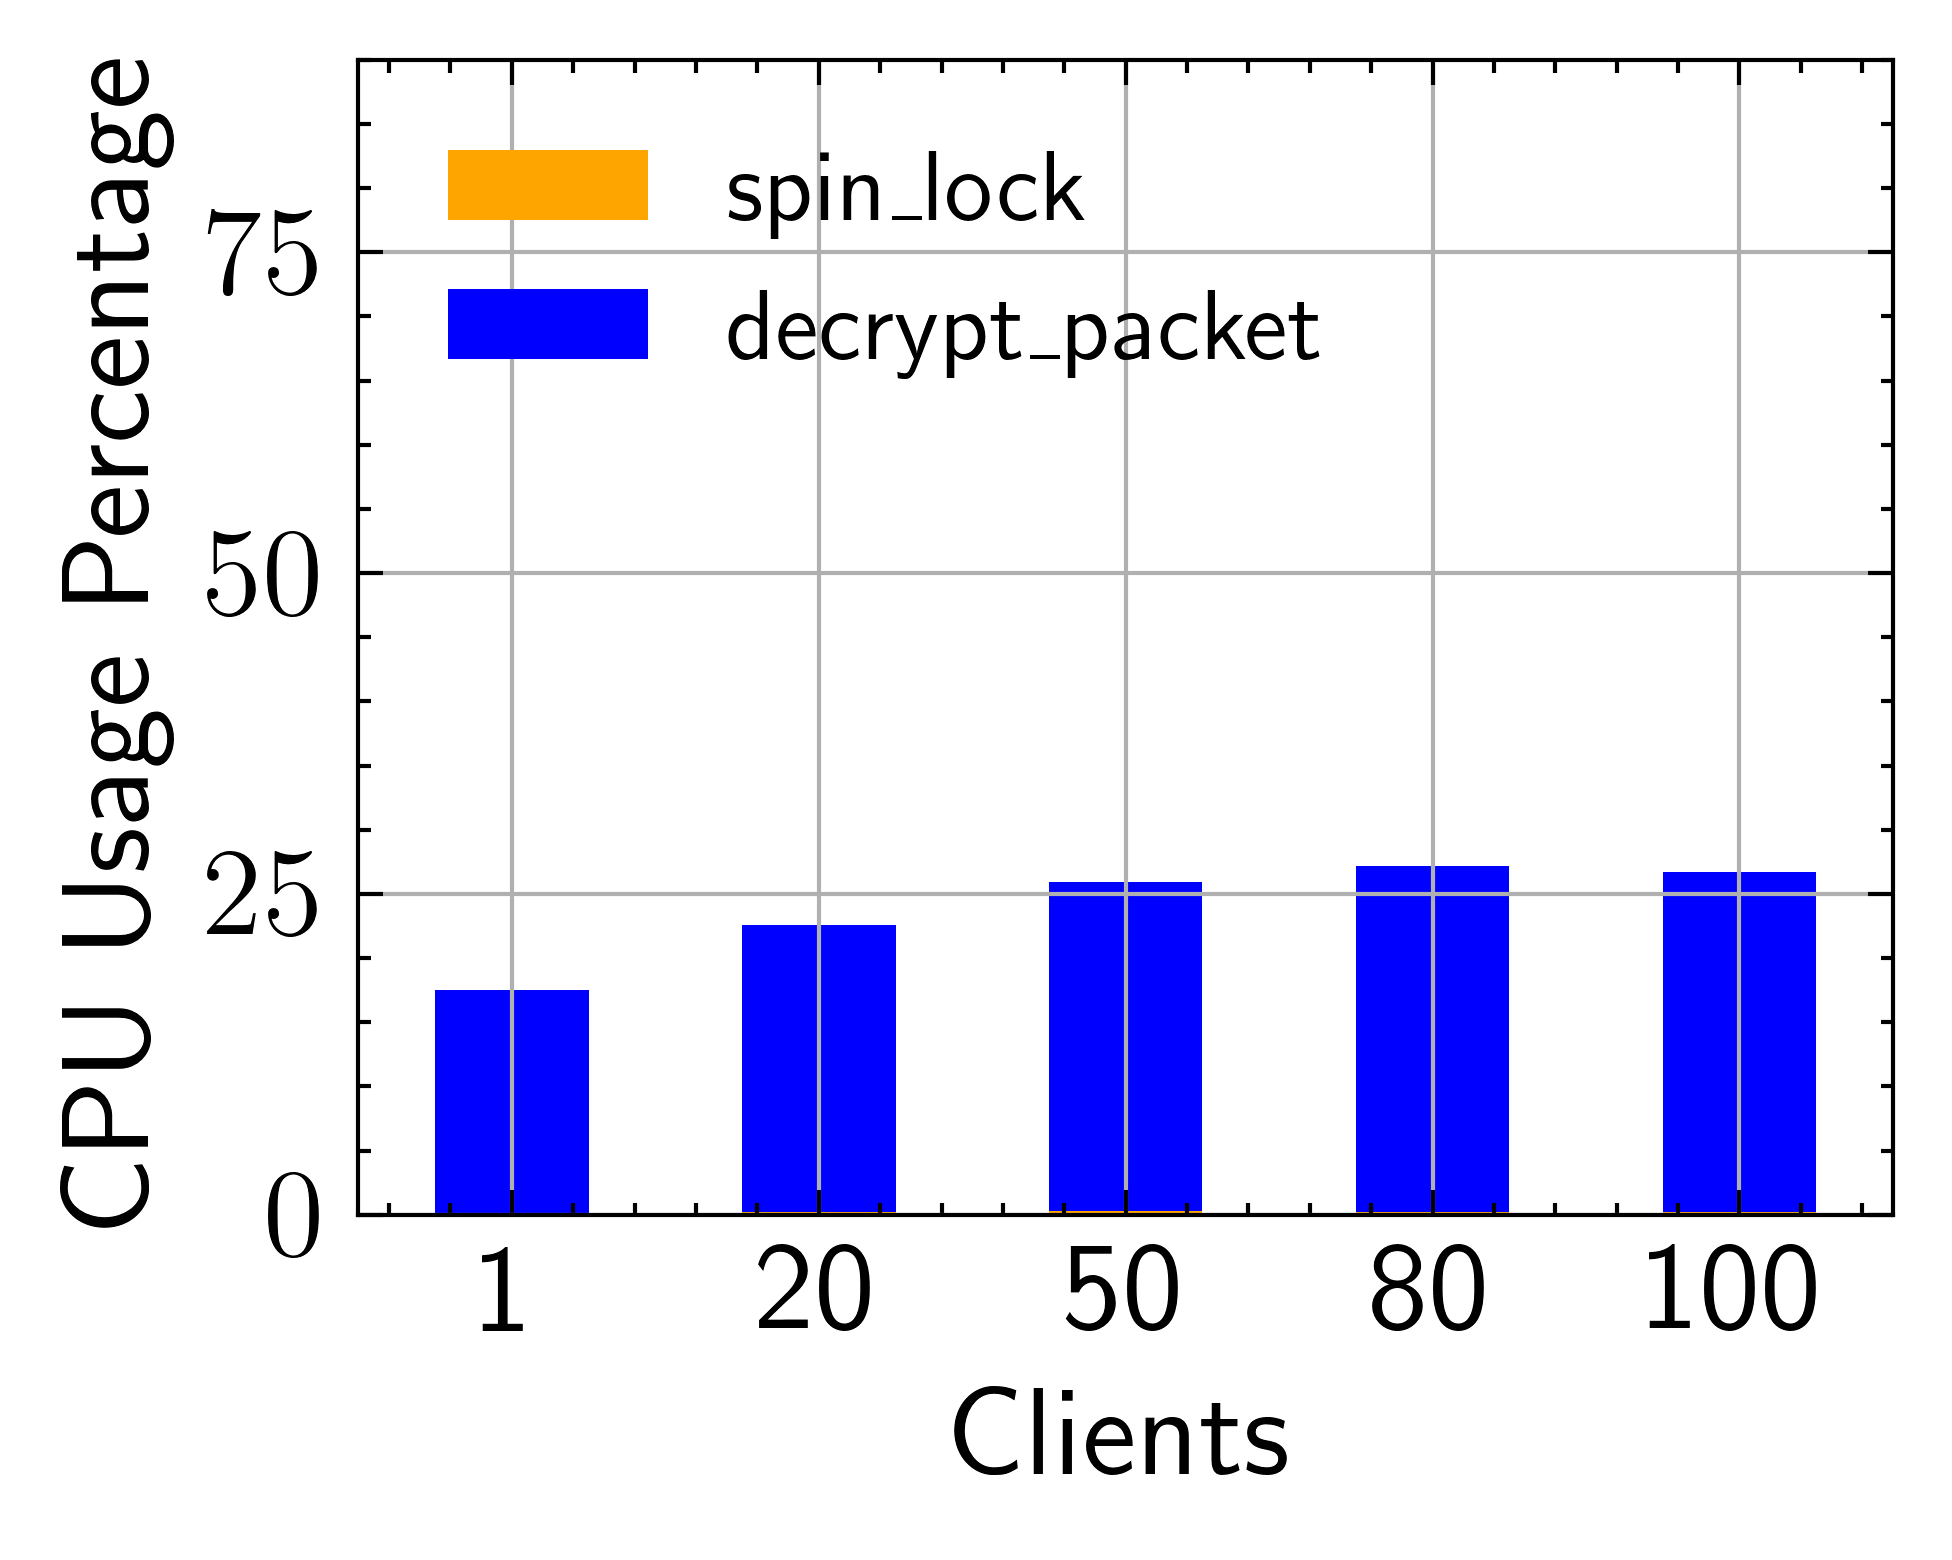

In [301]:
dir_ = "cryptonce-v2-2"
skip = 1
maindir = f"../{dir_}"
res_dirs = [infos_resdir(f) for f in os.listdir(maindir)]
index = find_index(res_dirs, 'no')
res_dirs.pop(index)
index = find_index(res_dirs, 'yes')
yes = res_dirs.pop(index)
res_dirs.insert(0, yes)
try:
    os.makedirs(f"../graphs/{dir_}")
except:
    pass

colors = ['black', 'red']
out_2 = compute_improvement(res_dirs, import_decrypt_absolute, 'decrypt_packet', index='clients', naming=naming_2)

plot_improvement(out_2, ylabel="Decryption CPU usage", annotate='difference', 
                 ylim=[0, 25], space=1, names=names_2, colors=colors,
                 savefig=f"../graphs/{dir_}/decryption_cpu.pdf",
                 figsize=(4, 3)
)

cols = ['spin_lock', 'decrypt_packet']
colors = ['orange', 'blue']

for res in res_dirs:
    df = import_decrypt(res['path'])[0].set_index('clients')
    with plt.style.context(['science', 'ieee']):
        df[cols].plot.bar(
            xlabel="Clients", ylabel="CPU Usage Percentage",
            stacked=True, ylim=[0, 90], color=colors, grid=True,
        )

        plt.xticks(rotation=0)
        plt.legend(loc='upper left', prop = {"size":12})
        plt.savefig(f"../graphs/{dir_}/spinratios_{res['name']}.pdf", dpi=300)
out_2

In [302]:
out_final = pd.concat([out, out_2], axis=1)

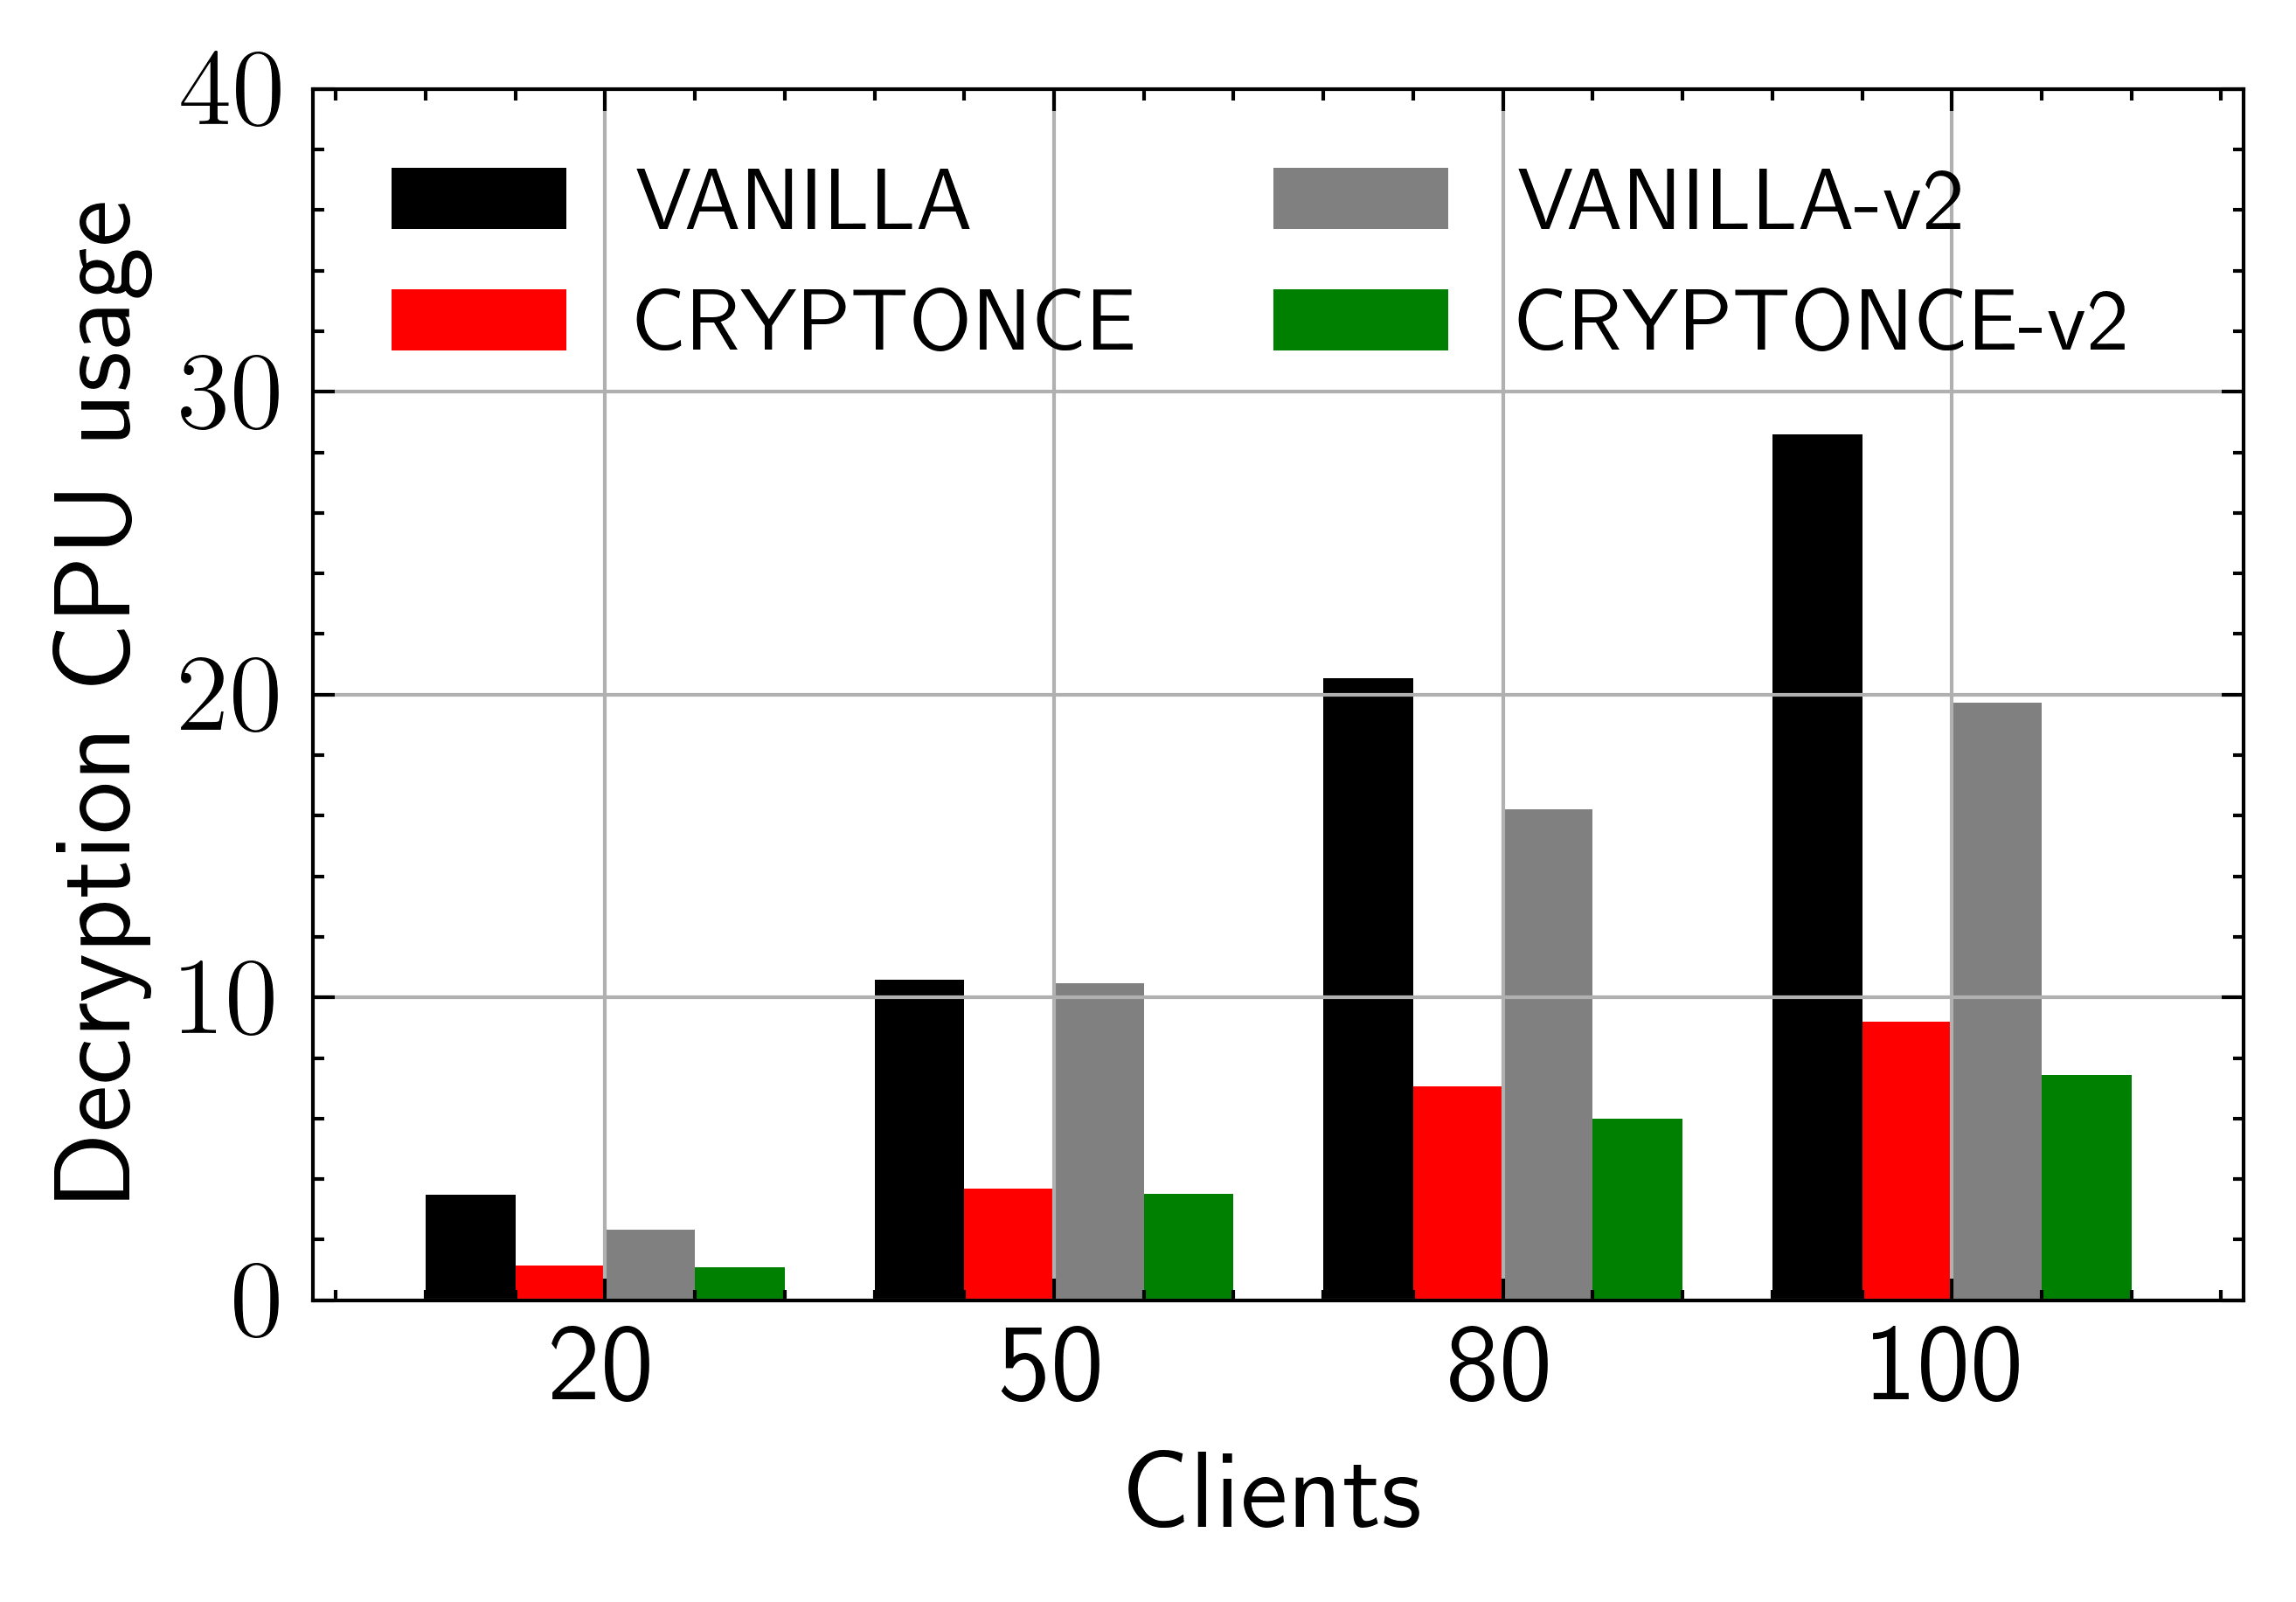

In [303]:
names_final = names + names_2
colors = ['black', 'red', 'gray', 'green']
plot_improvement(out_final, names=names_final, 
                 ylabel="Decryption CPU usage", 
                 ylim=[0, 40], space=1, colors=colors, annotate=None, 
                 n_cols=2, legend_size=12, figsize=(4.75, 3),
                 savefig=f"../graphs/{dir_}/decryption_cpu_1_2.pdf"
)